In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import os
from PIL import Image
from torchvision import transforms

In [12]:
csv_file_path = '/content/drive/My Drive/ikea/ikea.csv'

In [14]:
import pandas as pd
ikea_data = pd.read_csv(csv_file_path)

In [15]:
print(ikea_data.head())

   Unnamed: 0   item_id                   name       category   price  \
0           0  90420332               FREKVENS  Bar furniture   265.0   
1           1    368814              NORDVIKEN  Bar furniture   995.0   
2           2   9333523  NORDVIKEN / NORDVIKEN  Bar furniture  2095.0   
3           3  80155205                   STIG  Bar furniture    69.0   
4           4  30180504                NORBERG  Bar furniture   225.0   

      old_price  sellable_online  \
0  No old price             True   
1  No old price            False   
2  No old price            False   
3  No old price             True   
4  No old price             True   

                                                link other_colors  \
0  https://www.ikea.com/sa/en/p/frekvens-bar-tabl...           No   
1  https://www.ikea.com/sa/en/p/nordviken-bar-tab...           No   
2  https://www.ikea.com/sa/en/p/nordviken-nordvik...           No   
3  https://www.ikea.com/sa/en/p/stig-bar-stool-wi...          Yes   

In [16]:
print(ikea_data.isnull().sum())

Unnamed: 0              0
item_id                 0
name                    0
category                0
price                   0
old_price               0
sellable_online         0
link                    0
other_colors            0
short_description       0
designer                0
depth                1463
height                988
width                 589
dtype: int64


In [17]:
ikea_simplified = ikea_data[['category', 'link']]

In [18]:
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader

In [19]:
# Transforming input data
transform = transforms.Compose(
    [transforms.Resize(256),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

# Load the testing dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

100%|██████████| 170498071/170498071 [00:03<00:00, 48890198.11it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [20]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [25]:
for epoch in range(3):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}')

print('Finished Training')

Epoch 1, Loss: 0.09652942528063937
Epoch 2, Loss: 0.05282487907379589
Epoch 3, Loss: 0.033166797676210676
Finished Training


In [26]:
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 94 %


In [27]:
!pip install matplotlib

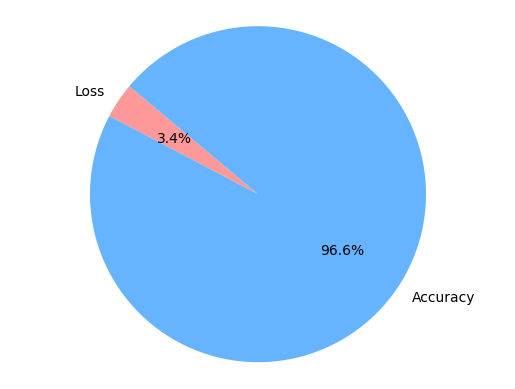

In [30]:
import matplotlib.pyplot as plt

final_loss = 0.033166797676210676
final_accuracy = 0.94

sizes = [final_loss, final_accuracy]
labels = ['Loss', 'Accuracy']
colors = ['#ff9999','#66b3ff']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.show()


In [31]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

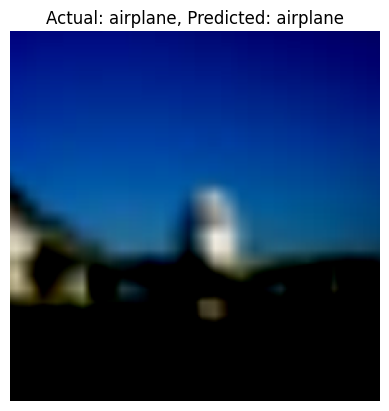

In [35]:
def random_prediction(model, dataset, classes, device):
    model.eval()
    idx = np.random.randint(0, len(dataset))
    image, label = dataset[idx]


    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')


    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)


    plt.title(f'Actual: {classes[label]}, Predicted: {classes[predicted.item()]}')
    plt.show()


cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

random_prediction(model, testloader.dataset, cifar_classes, device)
